In [ ]:
# !pip install yfinance

In [ ]:
# !pip install keras-tuner

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import hashlib
import json
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import keras_tuner as kt

In [3]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100.0

print("TensorFlow:", tf.__version__)
print("Using CUDA GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.20.0
Using CUDA GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
end_date = datetime.now()
start_date = end_date - timedelta(days=60)
end_date = "2025-11-24"
horizon = "30m"

print("Start date:", start_date)
print("End date:", end_date)

Start date: 2025-10-03 17:26:02.003623
End date: 2025-11-24


In [5]:
gold = yf.download("GC=F", start = start_date, end = end_date, interval = horizon, auto_adjust = False)
silver = yf.download("SI=F", start = start_date, end = end_date, interval = horizon,auto_adjust = False)
cad = yf.download("CADUSD=X", start = start_date, end = end_date, interval = horizon, auto_adjust = False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1606 entries, 2025-10-06 04:00:00+00:00 to 2025-11-24 04:30:00+00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, GC=F)  1606 non-null   float64
 1   (Close, GC=F)      1606 non-null   float64
 2   (High, GC=F)       1606 non-null   float64
 3   (Low, GC=F)        1606 non-null   float64
 4   (Open, GC=F)       1606 non-null   float64
 5   (Volume, GC=F)     1606 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 87.8 KB


In [7]:
silver.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1606 entries, 2025-10-06 04:00:00+00:00 to 2025-11-24 04:30:00+00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, SI=F)  1606 non-null   float64
 1   (Close, SI=F)      1606 non-null   float64
 2   (High, SI=F)       1606 non-null   float64
 3   (Low, SI=F)        1606 non-null   float64
 4   (Open, SI=F)       1606 non-null   float64
 5   (Volume, SI=F)     1606 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 87.8 KB


In [8]:
cad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1675 entries, 2025-10-03 16:00:00+00:00 to 2025-11-21 22:00:00+00:00
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, CADUSD=X)  1675 non-null   float64
 1   (Close, CADUSD=X)      1675 non-null   float64
 2   (High, CADUSD=X)       1675 non-null   float64
 3   (Low, CADUSD=X)        1675 non-null   float64
 4   (Open, CADUSD=X)       1675 non-null   float64
 5   (Volume, CADUSD=X)     1675 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 91.6 KB


In [9]:
def asset_heatmap(df, asset_name):
    plt.figure(figsize=(7, 5))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    plt.title(f"{asset_name} Feature Correlation Heatmap")
    plt.show()

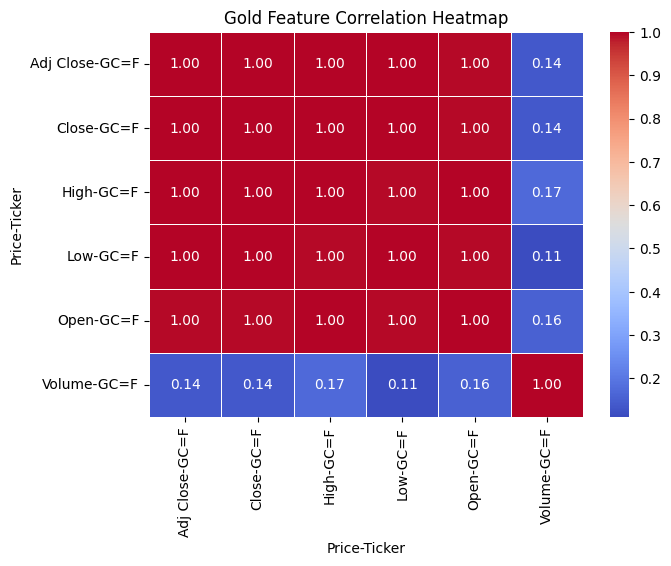

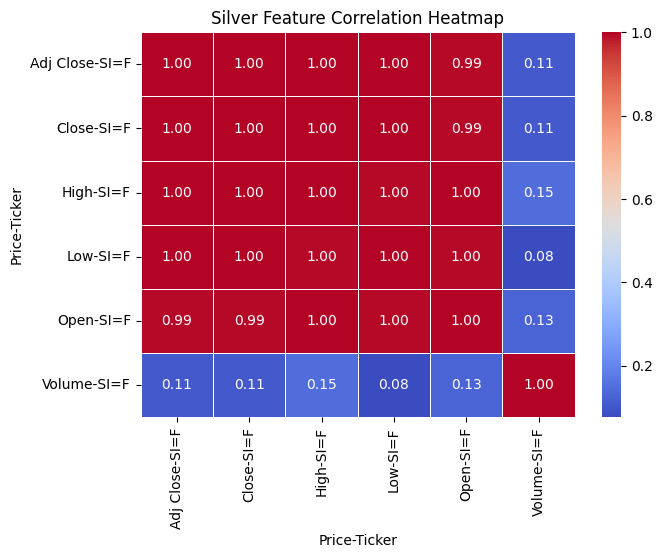

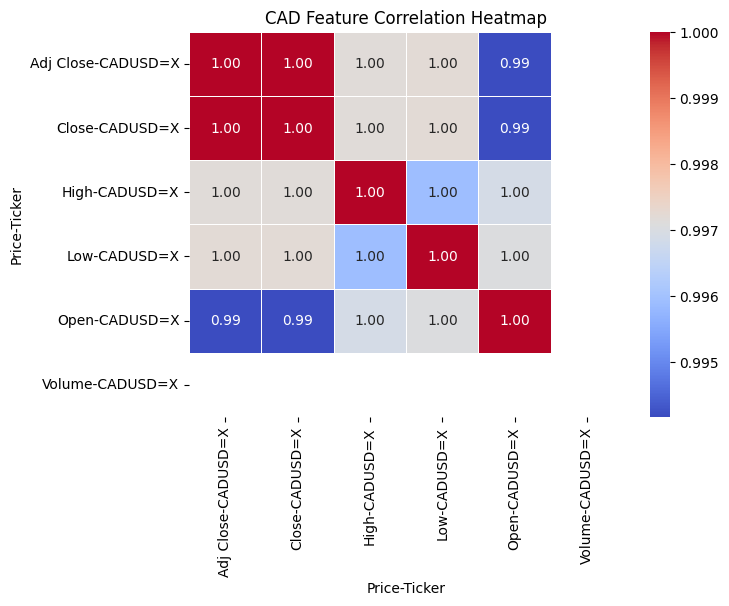

In [10]:
asset_heatmap(gold, "Gold")
asset_heatmap(silver, "Silver")
asset_heatmap(cad, "CAD")

In [11]:
gold = gold[["Close"]].rename(columns={"Close": "Gold"})
silver = silver[["Close"]].rename(columns={"Close": "Silver"})
cad = cad[["Close"]].rename(columns={"Close": "CAD"})

In [12]:
all_prices = gold.join([silver, cad], how="outer")
all_prices.to_csv("prices_with_null.csv")

In [13]:
all_prices = all_prices.ffill().bfill() # forward-fill + backward-fill to deal with missing values
all_prices.to_csv("prices.csv")

In [14]:
all_prices.head()

Price,Gold,Silver,CAD
Ticker,GC=F,SI=F,CADUSD=X
Datetime,,,
2025-10-03 16:00:00+00:00,3958.5,48.395,0.717206
2025-10-03 16:30:00+00:00,3958.5,48.395,0.716990
2025-10-03 17:00:00+00:00,3958.5,48.395,0.717051
2025-10-03 17:30:00+00:00,3958.5,48.395,0.716481
2025-10-03 18:00:00+00:00,3958.5,48.395,0.716676


In [15]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1698 entries, 2025-10-03 16:00:00+00:00 to 2025-11-24 04:30:00+00:00
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Gold, GC=F)     1698 non-null   float64
 1   (Silver, SI=F)   1698 non-null   float64
 2   (CAD, CADUSD=X)  1698 non-null   float64
dtypes: float64(3)
memory usage: 53.1 KB


In [16]:
all_prices.describe()

Price,Gold,Silver,CAD
Ticker,GC=F,SI=F,CADUSD=X
count,1698.000000,1698.000000,1698.000000
mean,4087.153179,49.433818,0.713290
std,101.194952,1.796099,0.002403
min,3912.000000,45.665001,0.707269
25%,4008.100098,48.070000,0.711982
50%,4067.399902,48.707500,0.713353
75%,4138.025024,50.744999,0.714739
max,4394.299805,54.299999,0.719746


## feature engineering

In [17]:
# # adding features that make more sense than raw data
# all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
# all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
# all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

# all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
# all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
# all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

# all_prices = all_prices.dropna()

In [18]:
# all_prices.head()

In [19]:
# all_prices.to_csv("prices_engineered.csv")

In [20]:
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(all_prices)

# scaled_prices = pd.DataFrame(scaled, index=all_prices.index, columns=all_prices.columns)

In [21]:
import tensorflow as tf

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [22]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(all_prices)

def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

In [23]:
max_window = 60

X_all, y_all = create_sequences(scaled, max_window)

split = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

In [24]:
# hyperparameter tuning

def build_model(hp):
    model = Sequential()
    
    window = hp.Int("window", min_value=10, max_value=60, step=10)
    
    rnn_type = hp.Choice("rnn_type", ["LSTM", "GRU"])
    rnn_layer = LSTM if rnn_type == "LSTM" else GRU

    # first layer
    model.add(
        rnn_layer(
            units=hp.Int("units_1", min_value=16, max_value=128, step=16),
            return_sequences=True,
            input_shape=(window, 3),
            kernel_regularizer=l2(hp.Choice("l2_reg", [1e-6, 1e-5, 1e-4])),
        )
    )
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.1)))

    # second layer
    model.add(
        rnn_layer(
            units=hp.Int("units_2", min_value=8, max_value=64, step=8),
            return_sequences=False,
            kernel_regularizer=l2(hp.Choice("l2_reg2", [1e-6, 1e-5, 1e-4])),
        )
    )
    model.add(Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.1)))

    # dense layer
    model.add(Dense(hp.Int("dense_units", 8, 64, step=8), activation="relu"))

    # output
    model.add(Dense(3))

    # learning rate
    lr = hp.Choice("learning_rate", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="mse",
        metrics=[rmse, mae, mape]
    )

    return model

In [25]:
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_rmse", direction="min"),
    max_trials=30,
    executions_per_trial=1,
    directory="tuning_results",
    project_name="model-30m",
)

Reloading Tuner from tuning_results/model-30m/tuner0.json


In [26]:
earlystop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

tuner.search(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[earlystop],
    verbose=1
)

In [27]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
best_hp.values

best_model = tuner.get_best_models(1)[0]

print(best_hp.values)
best_model.summary()

Best Hyperparameters:


I0000 00:00:1764689179.139200   98216 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1054 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/rita/anaconda3/envs/Python3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


{'window': 20, 'rnn_type': 'GRU', 'units_1': 112, 'l2_reg': 1e-06, 'dropout_1': 0.1, 'units_2': 40, 'l2_reg2': 0.0001, 'dropout_2': 0.1, 'dense_units': 32, 'learning_rate': 0.005}


/home/rita/anaconda3/envs/Python3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 20, 112)        │        39,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 112)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 40)             │        18,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,203 (231.26 KB)

 Trainable params: 59,203 (231.26 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

y_pred = best_model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("MAPE:", mape_val)

model = best_model

2025-12-02 17:26:19.717395: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
RMSE: 7.808355495180383
MAE : 3.5564265767854497
MAPE: 0.002175758892202263


In [29]:
y_pred = model.predict(X_test)

# inverse scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [30]:
baseline = scaler.inverse_transform(X_test[:, -1, :]) # last real point

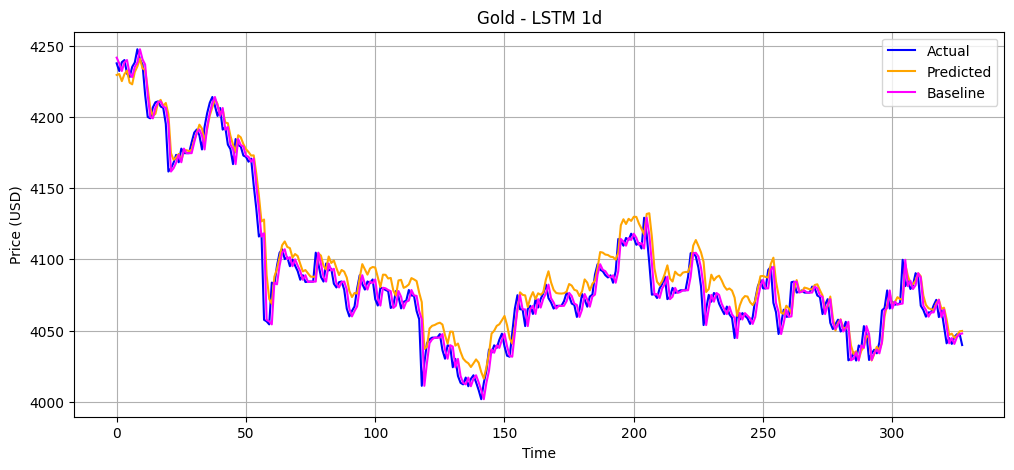

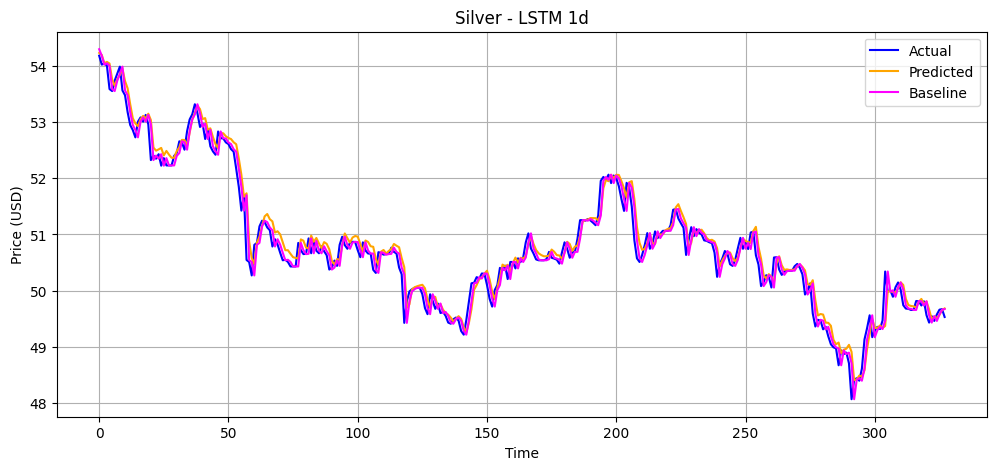

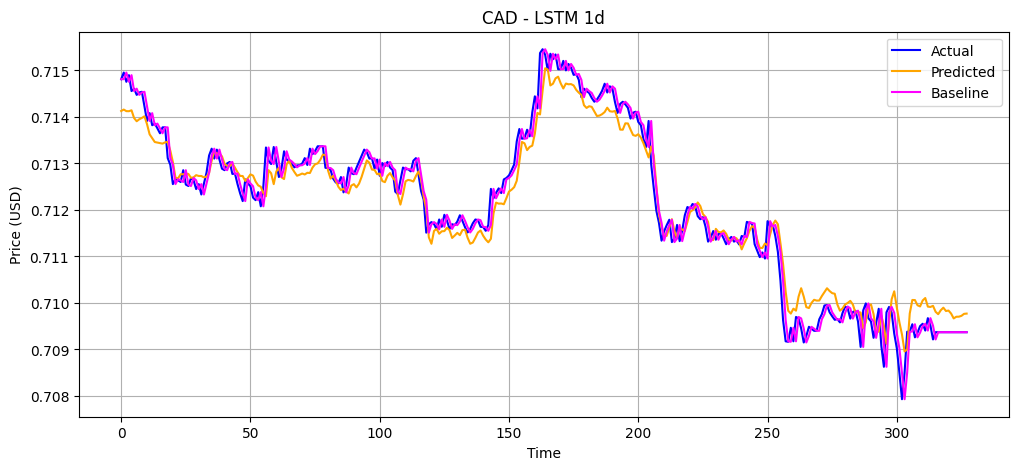

In [31]:
def plot_asset(i, asset_name):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_inv[:, i], label="Actual", color="blue")
    plt.plot(y_pred_inv[:, i], label="Predicted", color="orange")
    plt.plot(baseline[:, i], label="Baseline", color="magenta")
    plt.title(f"{asset_name} - LSTM 1d")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_asset(0, "Gold")
plot_asset(1, "Silver")
plot_asset(2, "CAD")

In [32]:
def mae(y, p): return np.mean(np.abs(y-p))
def rmse(y, p): return np.sqrt(np.mean((y-p)**2))
def mape(y, p): return np.mean(np.abs((y-p)/y))*100

assets = ["Gold","Silver","CAD"]
for i in range(3):
    print(assets[i])
    print(" MAE :", mae(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" RMSE:", rmse(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" MAPE:", mape(y_test_inv[:,i], y_pred_inv[:,i]))
    print()

Gold
 MAE : 10.492359440501172
 RMSE: 13.5223129269911
 MAPE: 0.25704489761080496

Silver
 MAE : 0.1765798359382441
 RMSE: 0.24145299393041655
 MAPE: 0.34786285067679823

CAD
 MAE : 0.00034045391693347837
 RMSE: 0.00041664433171512675
 MAPE: 0.04781991937307565



Enter date range exactly in this format inside the parenthesis, with the start date first (DD-MM-YYYY; DD-MM-YYYY): 20-11-2025; 28-11-2025


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


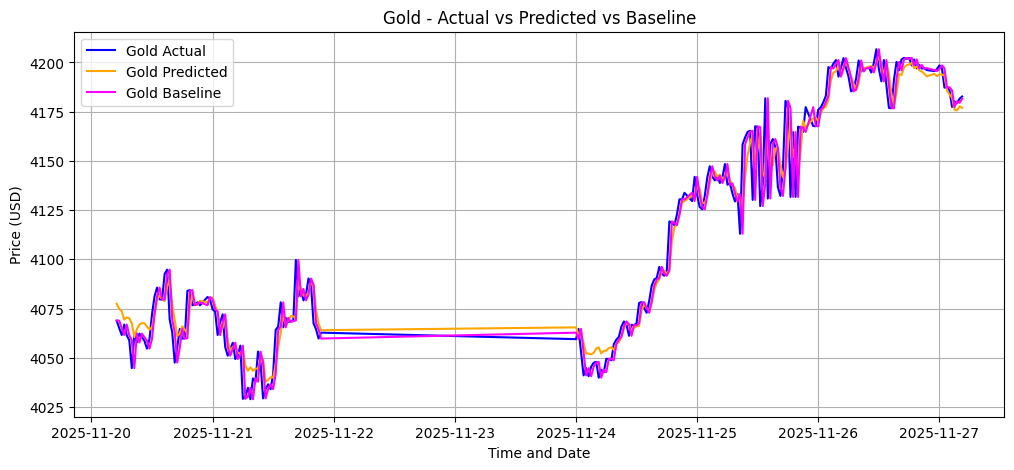

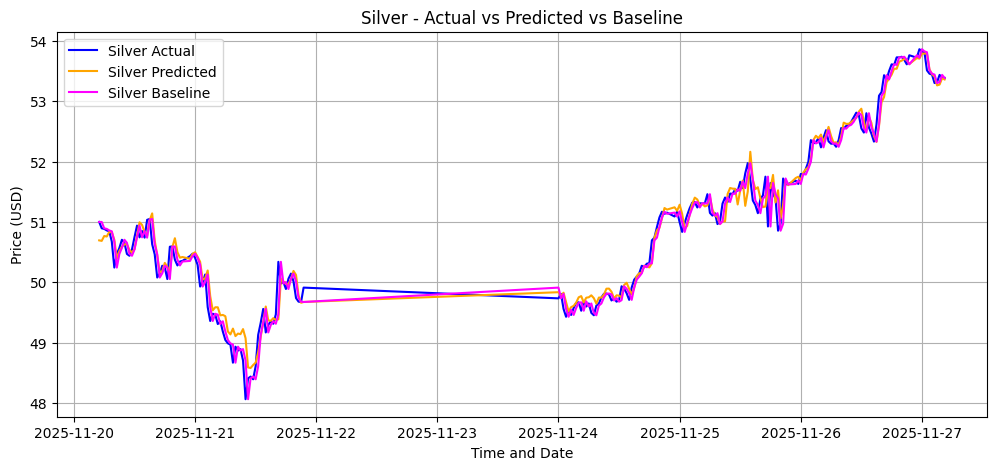

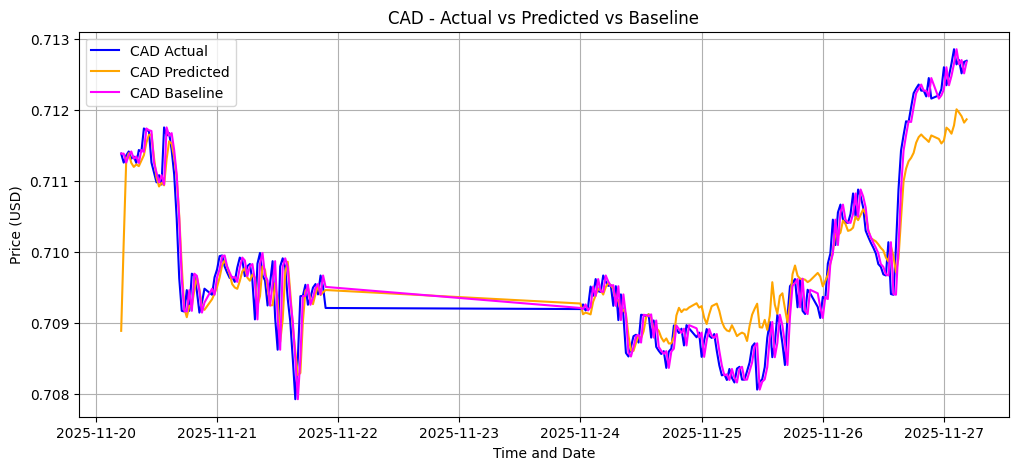

In [38]:
predict_window = 70

def parse_range(user_input): #format: DD-MM-YYYY; DD-MM-YYYY
   # Example: 10-12-2025; 14-12-2025
    if ";" not in user_input:
        raise ValueError("Invalid format. Use: DD-MM-YYYY; DD-MM-YYYY")

    parts = user_input.split(";")
    if len(parts) != 2:
        raise ValueError("Invalid format. Use: DD-MM-YYYY; DD-MM-YYYY")

    start_str = parts[0].strip()
    end_str   = parts[1].strip()

    try:
        start = datetime.strptime(start_str, "%d-%m-%Y")
        end   = datetime.strptime(end_str, "%d-%m-%Y")
    except:
        raise ValueError("Invalid date. Use exactly this format: DD-MM-YYYY; DD-MM-YYYY")

    return start, end

def user_date():
    while True:
        user_input = input("Enter date range exactly in this format inside the parenthesis, with the start date first (DD-MM-YYYY; DD-MM-YYYY): ")

        try:
            start, end = parse_range(user_input)
            return user_input
        except Exception as e:
            print(f"\nError: {str(e)}\nPlease try again.\n")


def predict_range(date_string, interval="30m"):
    start, end = parse_range(date_string)

    # downloading data to be able to compare with the actual value
    gold = yf.download("GC=F", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "Gold"})
    silver = yf.download("SI=F", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "Silver"})
    cad = yf.download("CADUSD=X", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "CAD"})
    
    
    data = gold.join([silver, cad], how="outer").dropna()

    if data.shape[0] == 0:
        raise ValueError(
            f"No Yahoo Finance data found between {start.date()} and {end.date()} "
            f"for interval='{interval}'. "
            "Try an earlier date range that already has price history."
        )

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X_seq = []
    last_seq = scaled[-predict_window:]
    window = np.vstack([scaled[-predict_window:], scaled_data])

    for i in range(len(data)):
        seq = window[i:i+predict_window]
        if seq.shape[0] == predict_window:
            X_seq.append(seq)

    X_seq = np.array(X_seq)

    preds = model.predict(X_seq)
    preds_inv = scaler.inverse_transform(preds)

    data["Gold_pred"], data["Silver_pred"], data["CAD_pred"] = (
        preds_inv[:, 0], preds_inv[:, 1], preds_inv[:, 2]
    )

    return data


def plot_results(df):
    assets = ["Gold", "Silver", "CAD"]
    for asset in assets:
        actual = df[asset].values
        predicted = df[f"{asset}_pred"].values
        
        # baseline: next price = current actual
        baseline = np.roll(actual, 1)
        baseline[0] = actual[0]  

        plt.figure(figsize=(12,5))
        plt.plot(df.index, actual, label=f"{asset} Actual", color="blue")
        plt.plot(df.index, predicted, label=f"{asset} Predicted", color="orange")
        plt.plot(df.index, baseline, label=f"{asset} Baseline", color="magenta")
        
        plt.title(f"{asset} - Actual vs Predicted vs Baseline")
        plt.xlabel("Time and Date")
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.grid(True)
        plt.show()


# 20-11-2025; 28-11-2025
user_range = user_date()
user_df = predict_range(user_range, interval="30m")
plot_results(user_df)

In [34]:
user_df.head()

Price,Gold,Silver,CAD,Gold_pred,Silver_pred,CAD_pred
Ticker,GC=F,SI=F,CADUSD=X,,,
Datetime,,,,,,
2025-11-20 05:00:00+00:00,4068.899902,51.000000,0.711389,4043.550049,49.584019,0.709706
2025-11-20 05:30:00+00:00,4065.100098,50.895000,0.711263,4073.937012,50.411160,0.710809
2025-11-20 06:00:00+00:00,4061.600098,50.884998,0.711364,4081.298584,50.739861,0.711509
2025-11-20 06:30:00+00:00,4066.899902,50.860001,0.711420,4075.229980,50.748737,0.711478
2025-11-20 07:00:00+00:00,4061.399902,50.845001,0.711318,4077.864502,50.843121,0.711443


Enter date range exactly in this format inside the parenthesis, with the start date first (DD-MM-YYYY; DD-MM-YYYY): 29-11-2025; 02-12-2025


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


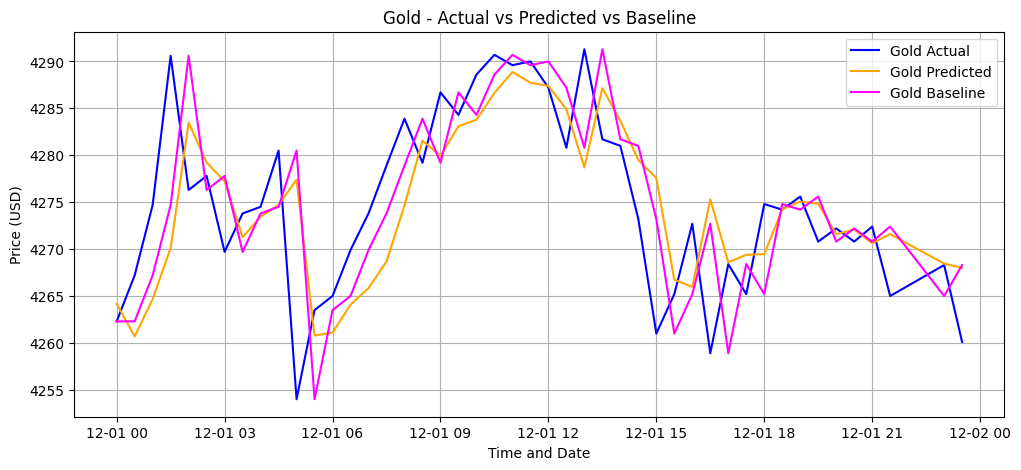

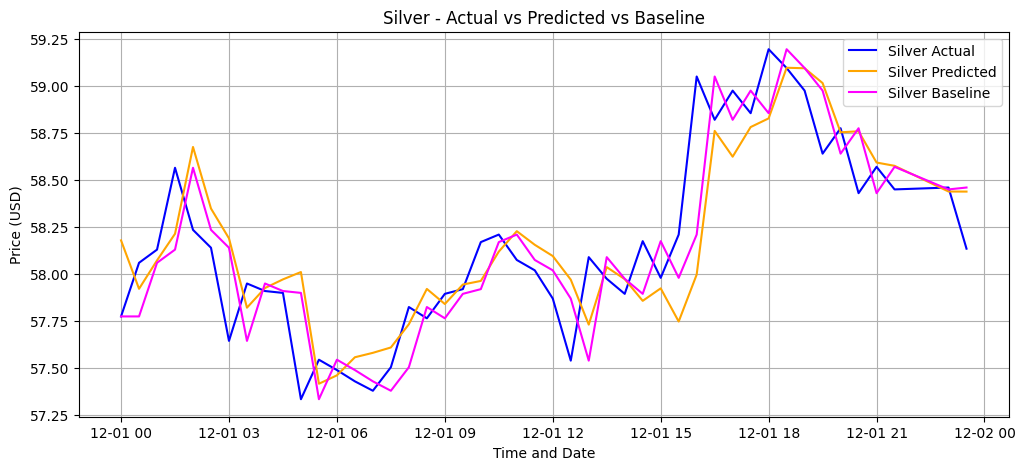

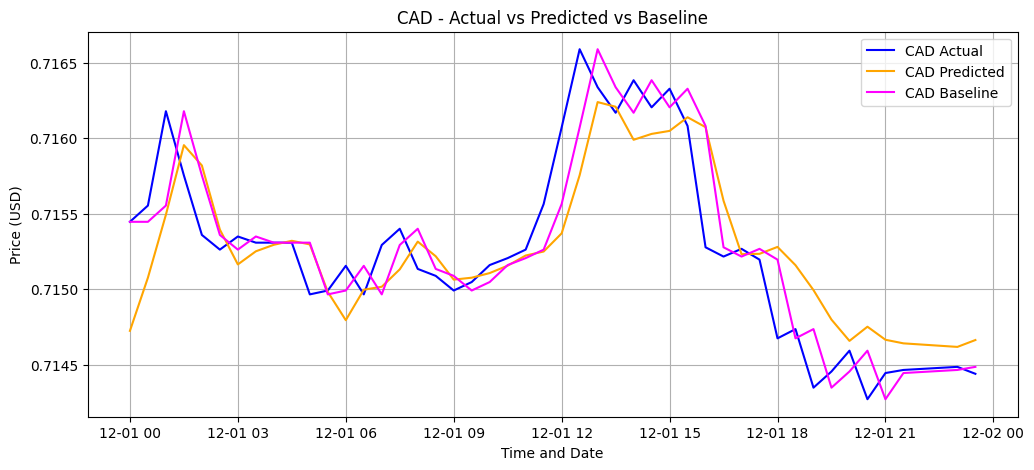

In [39]:
# 28-11-2025; 01-12-2025
user_range = user_date()
user_df = predict_range(user_range, interval="30m")
user_df.head()
plot_results(user_df)

In [36]:
user_df.head()

Price,Gold,Silver,CAD,Gold_pred,Silver_pred,CAD_pred
Ticker,GC=F,SI=F,CADUSD=X,,,
Datetime,,,,,,
2025-11-28 14:30:00+00:00,4233.500000,55.799999,0.715308,4043.550049,49.584019,0.709706
2025-11-28 15:00:00+00:00,4232.200195,55.799999,0.716173,4205.968750,53.383362,0.713374
2025-11-28 15:30:00+00:00,4239.299805,56.180000,0.717340,4242.473633,54.775513,0.715334
2025-11-28 16:00:00+00:00,4244.799805,56.314999,0.715820,4238.806152,55.113926,0.715719
2025-11-28 16:30:00+00:00,4242.100098,56.450001,0.715533,4253.602051,55.660160,0.715231


In [40]:
user_df.to_csv("predictions.csv")